### Imports packages

In [3]:
! pip install qmcpy --quiet
! pip install pytictoc --quiet
! pip install POT --quiet

  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/db/401hxrd10sb322p8704_k79h0000gn/T/pip-install-mc3o1g28/qmcpy/setup.py'"'"'; __file__='"'"'/private/var/folders/db/401hxrd10sb322p8704_k79h0000gn/T/pip-install-mc3o1g28/qmcpy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/db/401hxrd10sb322p8704_k79h0000gn/T/pip-wheel-h2uhr21l --python-tag cp37
       cwd: /private/var/folders/db/401hxrd10sb322p8704_k79h0000gn/T/pip-install-mc3o1g28/qmcpy/
  Complete output (112 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.7
  creating build/lib.macosx-10.9-x86_64-3.7/qmcpy
  copying qmcpy/__init__.py -> build/lib.macosx-10.9-x86_64-3.7/qmcpy
  crea

  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/db/401hxrd10sb322p8704_k79h0000gn/T/pip-install-mc3o1g28/qmcpy/setup.py'"'"'; __file__='"'"'/private/var/folders/db/401hxrd10sb322p8704_k79h0000gn/T/pip-install-mc3o1g28/qmcpy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' clean --all
       cwd: /private/var/folders/db/401hxrd10sb322p8704_k79h0000gn/T/pip-install-mc3o1g28/qmcpy
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: option --all not recognized
  ----------------------------------------
  ERROR: Failed cleaning build dir for qmcpy
    ERROR: Command errored out with exit

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm
import scipy.spatial.distance as distance
import qmcpy # QMC points
from pytictoc import TicToc # timer
import ot # Wasserstein distance and Sinkhorn divergence
from joblib import Parallel, delayed

ModuleNotFoundError: No module named 'qmcpy'

In [4]:
from joblib import Parallel, delayed
from math import modf

In [5]:
 r = Parallel(n_jobs=1)(delayed(modf)(i/2.) for i in range(10))

In [6]:
from time import sleep
from joblib import Parallel, delayed
r = Parallel(n_jobs=2, verbose=10)(delayed(sleep)(.2) for _ in range(10))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.3s finished


### Data simulation: $(X_1,\dots,X_n)$.

In [7]:
# Sample a dataset of size n from univariate Gaussians with a portion of outliers
def datagen(n,theta,contamination = []):
    datag = np.random.normal(loc=theta,scale=1,size=n-np.size(contamination))
    datag = np.concatenate((datag,contamination),axis=0)
    return(datag)

### Gaussian Kernel
Gaussian kernel $k(x,y)$

In [8]:
# compatible with old code
def k(x,y,l, sparse=False): 

    if sparse == True:
        x = x.astype('float32')
        y = y.astype('float32')
        
    x = np.matrix(x).transpose()
    y = np.matrix(y).transpose()
    # kernel
    kernel = np.exp(-l*distance.cdist(x,y,'sqeuclidean'))
    
    return kernel

Gaussian kernel $k(x,y)$, its gradient w.r.t. first element $\nabla_1k(x,y)$ and its second derivative w.r.t. to the second and first argument $\nabla_2\nabla_1k(x,y)$:

In [9]:
def k(x,y,l, sparse=False): 

    if sparse == True:
        x = x.astype('float32')
        y = y.astype('float32')
    
    # dimensions
    d = x.shape[1]
    dims = np.arange(d)
    
    # kernel
    kernel = np.exp(-(1/(2*l**2))*distance.cdist(x,y,'sqeuclidean'))
    
    # first derivative
    grad_1 = -1*np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0)*(1/l**2)*np.expand_dims(kernel, axis=0)
    
    #second derivative
    grad_21 = (1/l**2)*(np.expand_dims(np.expand_dims(np.eye(d), axis = 2), axis = 3)-np.einsum('ijk,ljk->iljk',np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0),np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0))*(1/l**2))*kernel
    
    return list([kernel, grad_1, grad_21])

### $MMD^2$ approximation

In [10]:
def MMD_approx(n,m,kxx,kxy,kyy):
    """y_{i=1}^n iid from P_\theta, x_{i=1}^m iid from Q
    kxx is nxn, kyy is mxm and kxy is nxm"""
    
    # first sum
    np.fill_diagonal(kyy, np.repeat(0,n)) # exclude k(y_i, y_i) (diagonal terms)
    sum1 = np.sum(kyy)
    
    # second sum
    sum2 = np.sum(kxy)
    
    # third sum
    np.fill_diagonal(kxx, np.repeat(0,m))
    sum3 = np.sum(kxx)
    
    return (1/(n*(n-1)))*sum1-(2/(m*n))*sum2+(1/(m*(m-1)))*sum3

### MMD$^2$ gradient approximation between $P_{\theta}$ and $\sum_{i=1}^n w_i \delta_{x_i}$:

In [11]:
def grad_MMD(n,m,weights,kyy,kxy,theta,sample):   
    # y sample from p_theta, x data
    # gradient of log(p_theta(X)) w.r.t. theta
    grad_ = theta*np.ones(n) - sample # or m? check
    # weights
    weights_mat = np.tile(weights, (n,1))
    # first sum
    np.fill_diagonal(kyy, np.repeat(0,n))
  
    # second (weighted) sum 
    w_ = np.multiply(weights_mat,kxy)
    
    return -2*np.mean(grad_*(kyy)/(n-1)- 2*sum(grad_*w_))

### Computation of the Maximum Likelihood Estimator (the mean) $\frac{1}{n}\sum_{i=1}^n X_i$ and the geometric median

In [12]:
def MLE(data):
    return(np.mean(data))

In [13]:
def GEO_MED(data):
    return(np.median(data))

### NPL

In [14]:
class NPL():
    """This class contains everything that is needed for inference with a 
    given model. 
    """
    
    def __init__(self, B):
        self.B = B
        
    
    def draw_samples(self, X, seed = 0, display_opt = True, gamma=1):
        """Draws B samples from the nonparametric posterior specified via
        the likelihood and the data X"""
        
        print("Drawing samples...")    
        n = X.shape[0]
        self.kxx = k(X,X,gamma)
        self.n = n
        self.m = n   # can put m as an input later - for now I choose n=m 
        sample = []
        wll = []
        mmd_loss = []
        
        
#         #Parallelize bootstrap
#     if R_restarts == 0: #FI-NPL (with MLE initialization to select single mode)
#         pi_init_mle,mu_init_mle,sigma_init_mle = mgmm.init_params(y,N_data,K_clusters,D_data,tol,max_iter)
#         temp = Parallel(n_jobs=n_cores, backend= 'loky')(delayed(mgmm.maximise_mle)(y,weights[i],pi_init_mle,\
#             mu_init_mle,sigma_init_mle,K_clusters,tol,max_iter,N_data) for i in tqdm(range(B_postsamples))) 
#     else:
#         temp = Parallel(n_jobs=n_cores, backend= 'loky')(delayed(mgmm.maximise)(y,y_prior[i],weights[i],\
#             pi_init[i*R_restarts:(i+1)*R_restarts],mu_init[i*R_restarts:(i+1)*R_restarts],sigma_init[i*R_restarts:(i+1)*R_restarts],\
#             alph_conc, T_trunc,K_clusters,tol,max_iter,R_restarts,N_data,D_data, postsamples = postsamples) for i in tqdm(range(B_postsamples)))
        
        for j in tqdm(range(self.B)):
            
            # draw Dirichlet weights
            weights = dirichlet.rvs(np.ones(self.n), size = 1, random_state = seed).flatten()
            
            # compute WLL minimizer
            wll_j = self.WLL(X, weights)
            
            # compute MMD minimizer
            theta_j, loss_j = self.minimise_MMD(X, weights)    # for now just for gaussian
            
            # add to sample
            sample = sample + [theta_j]
            wll = wll + [wll_j]
            mmd_loss = mmd_loss + [loss_j]
            
            # add +1 to the seed for the next sample
            seed = seed + 1
                
               
        self.sample = np.array(sample)
        self.wll = np.array(wll)
        self.mmd_loss = np.array(mmd_loss)
    
    def outerdiff(self, v1,v2):
        """Create a matrix of differences between vector components"""
        #m = sum(v1[:, None]-v2,axis=2)
        m = v1[:, None]-v2
        return(np.matrix(m))
    
    def MMD_approx(self,weights,kxy,kyy):
        """y_{i=1}^n iid from P_\theta, x_{i=1}^m iid from Q
        kxx is nxn, kyy is mxm and kxy is nxm"""
        weights_mat = np.tile(weights, (self.n,1))
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,self.n)) # exclude k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        #sum2 = np.sum(kxy)
        sum2 = np.sum(np.multiply(weights_mat, kxy))
    
        # third sum
        np.fill_diagonal(self.kxx, np.repeat(0,self.m))
        #sum3 = np.sum(self.kxx)
        sum3 = np.sum(np.multiply(weights_mat,self.kxx))
    
        return (1/(self.n*(self.n-1)))*sum1-(2/(self.m*self.n))*sum2+(1/(self.m*(self.m-1)))*sum3


    def grad_MMD(self,weights,kyy,kxy,theta,sample):   
        # y sample from p_theta, x data
        # gradient of log(p_theta(y)) w.r.t. theta
        grad_ = theta*np.ones(self.n) - sample # or m? check
        # weights
        weights_mat = np.tile(weights, (self.n,1))
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,self.n))
  
        # second (weighted) sum 
        w_ = np.multiply(weights_mat,kxy)
    
        return -2*np.mean(grad_*(kyy)/(n-1)- 2*sum(grad_*w_))


    def minimise_MMD(self, data, weights, Nstep=1000 ,gamma=1, eta=0.1):
        """Gaussian kernel of parameter gamma=1
        Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
        """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
        theta = 0.0
        t = 0
        gradient = 100
        while t < Nstep and abs(gradient) > 0.0001: 
            #print("---Performing step", t, "of SGD---")
            #print("Minimizing MMD...")
            sample = np.random.normal(loc=theta,scale=1,size=self.n)
            kyy = np.matrix(k(sample,sample,gamma))
            kxy = np.matrix(k(sample,data,gamma))
            #kxx = np.matrix(k(data,data,gamma))
            gradient = self.grad_MMD(weights,kyy,kxy,theta,sample)
            theta -= eta*gradient
            t += 1
        #print("stopped after", t, "steps")
        loss = MMD_approx(n,n,self.kxx,kxy,kyy)
        return theta, loss
        
    def WLL(self, data, weights):
        """Get weighted log likelihood minimizer, for gaussian model"""
        theta = 0
        for i in range(self.n):
            theta += weights[i]*data[i] 
        return theta

In [14]:
start_time = time.time()
theta = 0
n = 500 
N = 1
B = 1000
outl = 5
results = np.zeros([3*outl,N]) #for i in arange(N):
for n_cont in np.arange(outl):
    for i in range(N):
        print("-----Running for", n_cont*5, "% of outliers-----")
        normal_contamination = np.random.normal(loc=5,scale=1,size=int(np.floor(int(n_cont)*5/100*n)))
        X = datagen(n=n,theta=theta,contamination=normal_contamination) 
        npl = NPL(B)
        npl.draw_samples(X)
        sample = npl.sample
        wll_sample = npl.wll
        mmd_loss = npl.mmd_loss
        results[n_cont*3,i] = np.mean((theta-sample)**2)
        results[n_cont*3+1,i] = np.mean((theta-MLE(X))**2)
        results[n_cont*3+2,i] = np.mean((theta-wll_sample)**2)
    vec_res = np.mean(results,axis=1)      # swsto auto edw?
end_time = time.time()
print('Time :', end_time-start_time, 'seconds')
for n_cont in np.arange(outl):
    print('MSE of MMD for', n_cont*5, '% of outliers :', (vec_res[n_cont*3+0]))
    print('MSE of MLE for', n_cont*5, '% of outliers :', (vec_res[n_cont*3+1]))
    print('MSE of WLL for', n_cont*5, '% of outliers :', (vec_res[n_cont*3+2]))

-----Running for 0 % of outliers-----
Drawing samples...



-----Running for 5 % of outliers-----
Drawing samples...



-----Running for 10 % of outliers-----
Drawing samples...



-----Running for 15 % of outliers-----
Drawing samples...



-----Running for 20 % of outliers-----
Drawing samples...



Time : 820.1160960197449 seconds
MSE of MMD for 0 % of outliers : 0.01581632801501522
MSE of MLE for 0 % of outliers : 0.00985173125741424
MSE of WLL for 0 % of outliers : 0.011770067260899698
MSE of MMD for 5 % of outliers : 0.003297420958382847
MSE of MLE for 5 % of outliers : 0.08999701750857216
MSE of WLL for 5 % of outliers : 0.09614461987458364
MSE of MMD for 10 % of outliers : 0.0030133224296601388
MSE of MLE for 10 % of outliers : 0.230645730626799
MSE of WLL for 10 % of outliers : 0.23578785794586354
MSE of MMD for 15 % of outliers : 0.0060471343488968255
MSE of MLE for 15 % of outliers : 0.6179147690702497
MSE of WLL for 15 % of outliers : 0.6254522566271669
MSE of MMD for 20 % of outliers : 0.0036127202875990178
MSE of MLE for 20 % of outliers : 1.0210796649309293
MSE of WLL for 20 % of outliers : 1.0358507794011818


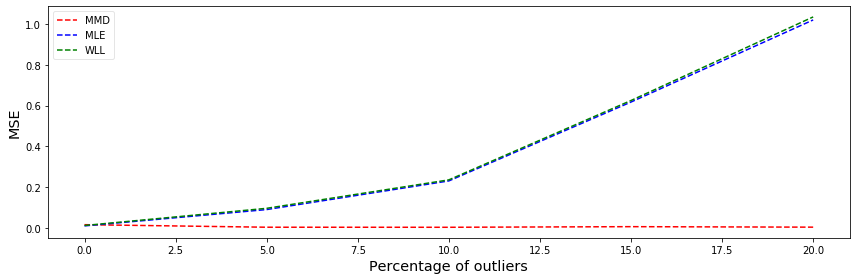

In [15]:
fig = plt.figure(figsize=(18, 18))

#plt.subplot(1, 2, 1,)
results_mmd = []
results_mle = []
results_wll = []
for i in np.arange(outl):
    results_mmd.append(vec_res[i*3+0])
    results_mle.append(vec_res[i*3+1])
    results_wll.append(vec_res[i*3+2])

plt.plot(np.linspace(0,4*outl,outl), results_mmd, 'r--', label='MMD')
plt.plot(np.linspace(0,4*outl,outl), results_mle, 'b--', label='MLE')
plt.plot(np.linspace(0,4*outl,outl), results_wll, 'g--', label='WLL')
#plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+2], 'g--', label='MED')
#plt.plot(arange(0,0.30,0.05), vec_res[arange(outl)*4+3], 'p+-', label='VI')
leg = plt.legend(loc='best', ncol=1)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Percentage of outliers',fontsize='x-large')
plt.ylabel('MSE',fontsize='x-large')

# plt.subplot(1, 2, 2)
# plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+0], 'r--', label='MMD')
# plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+2], 'g--', label='MED')
# #plt.plot(arange(0,0.30,0.05), vec_res[arange(outl)*4+3], 'p+-', label='VI')
# leg = plt.legend(loc='best', ncol=1)
# leg.get_frame().set_alpha(0.5)
# plt.xlabel('Ratio of outliers',fontsize='x-large')
# plt.ylabel('Sqrt of MSE',fontsize='x-large')

fig.set_size_inches(12, 4)

plt.tight_layout()

Text(0, 0.5, 'MMD^2 loss')

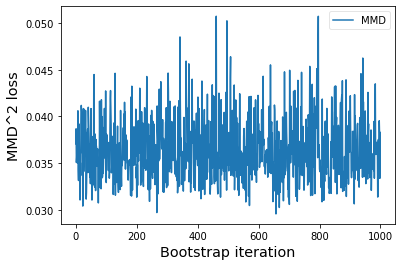

In [16]:
plt.plot(range(B), mmd_loss, label='MMD')
leg = plt.legend(loc='best', ncol=1)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Bootstrap iteration',fontsize='x-large')
plt.ylabel('MMD^2 loss',fontsize='x-large')

In [146]:
np.savetxt(fname='01_res.txt', X=vec_res)

In [ ]:
# old mmd function inside NPL class
#     def MMD(self, data, weights, Nstep=1000 ,gamma=1, eta=0.2):
#         """Gaussian kernel of parameter gamma=1
#         Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
#         """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
#         theta = 0.0
#         t = 0
#         gradient = 100
#         while t < Nstep and abs(gradient) > 0.0001: 
#            #print("---Performing step", t, "of SGD---")
#            #print("Minimizing MMD...")
#             sample = np.random.normal(loc=theta,scale=1,size=self.n) 
#             K1 = self.outerdiff(v1=sample,v2=data)
#             K2 = self.outerdiff(v1=sample,v2=sample)
#             diff = theta*np.ones(self.n)-sample
#             weights_mat = np.tile(weights, (self.n,1))
#         #gradient = -2*(mean(diff*(exp(-gamma*multiply(K2,K2))-diag(ones(n))))/(n-1)-mean(diff*exp(-gamma*multiply(K1,K1))))
#             gradient = -2*np.mean(diff*(np.exp(-gamma*np.multiply(K2,K2))-np.diag(np.ones(self.n)))/(self.n-1)-
#                             sum(diff*np.multiply(weights_mat, np.exp(-gamma*np.multiply(K1,K1)))))
#             theta = theta-eta*gradient/np.sqrt(t+1)
#             t += 1
#         #print("stopped after", t, "steps")
#         return theta

### Test MMD convergence

In [335]:
def outerdiff(v1,v2):
    """Create a matrix of differences between vector components"""
    #m = sum(v1[:, None]-v2,axis=2)
    m = v1[:, None]-v2
    return(np.matrix(m))

In [451]:
def MMD_(data, weights, Nstep=1000 ,gamma=1, eta=0.1):
    """Gaussian kernel of parameter gamma=1
    Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
    """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
    n = data.shape[0]
    thetas = []
    theta = 0.0
    grads = []
    losses = []
    t = 0
    gradient = 100
    while t < Nstep and abs(gradient) > 0.0001: 
        #print("---Performing step", t, "of SGD---")
        #print("Minimizing MMD...")
        sample = np.random.normal(loc=theta,scale=1,size=n)
        K1 = outerdiff(v1=sample,v2=data)
        K2 = outerdiff(v1=sample,v2=sample)
        diff = theta*np.ones(n)-sample
        kyy = np.matrix(k(sample,sample,gamma))
        kxy = np.matrix(k(sample,data,gamma))
        kxx = np.matrix(k(data,data,gamma))
        weights_mat = np.tile(weights, (n,1))
        gradient = grad_MMD(n,n,weights,kyy,kxy,theta,sample)
        #gradient = -2*np.mean(diff*(kyy)/(n-1)- 2*sum(diff*np.multiply(weights_mat, kxy)))
        #grads.append(gradient)
        theta -= eta*gradient
        loss = MMD_approx(n,n,kxx,kxy,kyy)
        losses.append(loss)
        thetas.append(theta)
        t += 1
    print("stopped after", t, "steps")
    return theta, thetas, losses, t

In [452]:
n=500
theta=2
weights = dirichlet.rvs(np.ones(n), size = 1).flatten()
X = datagen(n=n,theta=theta,contamination=np.random.standard_cauchy(100))           
theta_star, thetas, losses, iterations = MMD_(X, weights)

stopped after 213 steps


<function matplotlib.pyplot.show(*args, **kw)>

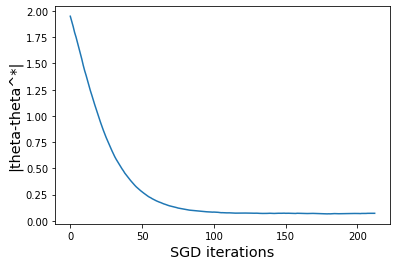

In [453]:
plt.plot(range(iterations),abs(thetas-theta*np.ones(iterations)))
plt.xlabel('SGD iterations',fontsize='x-large')
plt.ylabel('|theta-theta^*|',fontsize='x-large')

plt.show

Text(0, 0.5, 'MMD^2 loss')

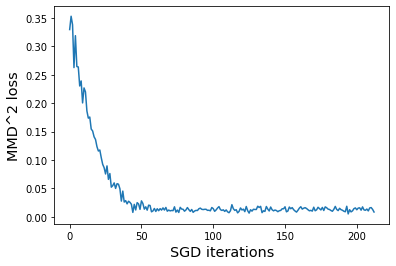

In [454]:
plt.plot(range(iterations), losses)
plt.xlabel('SGD iterations', fontsize='x-large')
plt.ylabel('MMD^2 loss', fontsize='x-large')